In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import torch
from utils.detect import FaceDetector
from model.mtcnn_pytorch import PNet, RNet,ONet
import matplotlib.pyplot as plt
import time
from functools import wraps


In [7]:
def show_boxes(img, boxes):
    
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)  
    for box in boxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

import matplotlib.pyplot as plt

def create_donut_chart(times, heading=None, labels=None, sizes=None, colors=None, explode=None, ax=None):
    if labels is None:
        labels = list(times.keys())
    if sizes is None:
        sizes = list(times.values())
    if colors is None:
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][:len(labels)]
    if explode is None:
        explode = [0.1] + [0] * (len(labels) - 1)

    if ax is None:
        fig, ax = plt.subplots()

    ax.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
    
    # Draw circle
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Print another value in the middle
    total_time = sum(times.values())
    ax.text(0, 0, f'{total_time:.4f}s', horizontalalignment='center', verticalalignment='center', fontsize=20, color='black')

    # Add heading
    if heading:
        ax.set_title(heading)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    plt.tight_layout()

    if ax is None:
        plt.show()


def get_avg_values(profDict,itersize):
    out = {}
    for key,value in profDict.items():
        
        if key == '_generate_bboxes':
            avg_value = sum(value[5:])/(len(value[2:]))
        else:
            if isinstance(value,list): 
                avg_value = sum(value[5:])/len(value[2:])
            else:
                avg_value = value
        
        out[key] = avg_value
    return out


In [9]:
#Load Models
pnet = torch.jit.load("output/trainedModels/pnet_sc.pt")
rnet = torch.jit.load("output/trainedModels/rnet_sc.pt")
onet = ONet()
onet.load_caffe_model(
    np.load("output/trainedModels/onet.npy",allow_pickle=True)[()])

Detection on Three Stage MTCNN


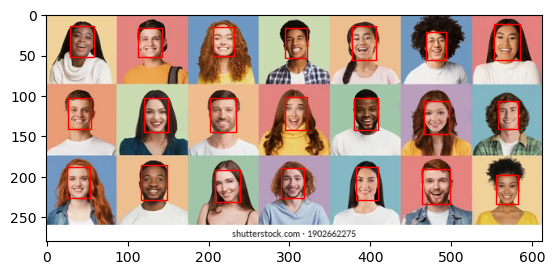

Detection on Two Stage MTCNN


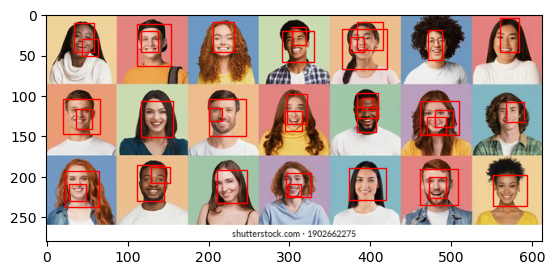

In [55]:
fd3stage = FaceDetector(pnet=pnet,rnet = rnet,onet = onet,device="cpu",prof=True,use3stage = True,use_jit = False)
fd2stage = FaceDetector(pnet=pnet,rnet = pruned_rnet_model,onet = onet,device="cpu",prof=True,use3stage = False,use_jit = False)

#Load Image
im_dir = "image.png"
img = Image.open(im_dir)
profs_2stage = []
profs_3stage = []
itersize = 1
for i in range(itersize):

    #Detect faces on three stage MTCNN P R and O Net
    boxes3stage = fd3stage.detect(im_dir)

    #Detect Faces on two stage MTCNN P R Net
    boxes2stage = fd2stage.detect(im_dir)
    box2stage_prof = fd2stage.get_prof()
    box3stage_prof = fd3stage.get_prof()


print("Detection on Three Stage MTCNN")
show_boxes(img,boxes3stage)
print("Detection on Two Stage MTCNN")
show_boxes(img,boxes2stage)


In [56]:
prof3stage = get_avg_values(fd3stage.get_prof(),itersize)
prof2stage = get_avg_values(fd2stage.get_prof(),itersize)

ZeroDivisionError: division by zero

In [ ]:
#Analysis of 2 stage MTCNN 
stage_one_time = {"pnet":prof2stage['pnet'],
                  "_generate_bboxes": prof2stage['_generate_bboxes'],
                  "_calibrate_box": prof2stage['_calibrate_box'],
                  "nms_stage_one": prof2stage['nms_stage_one']}
stage_two_time = {"rnet":prof2stage['rnet'],
                  "_generate_bboxes": prof2stage['_generate_bboxes'],
                  "_calibrate_box": prof2stage['_calibrate_box']*2,
                  "nms_stage_two": prof2stage['nms_stage_two'],
                  "_convert_to_square": prof2stage['_convert_to_square']}

total_nms_time = stage_one_time['nms_stage_one']+ stage_two_time['nms_stage_two']
preprocess_time = prof2stage['_preprocess']
misc_time = stage_one_time['_generate_bboxes'] + stage_one_time['_calibrate_box'] + stage_two_time['_calibrate_box'] +stage_two_time['_generate_bboxes']
model_inference_time = stage_one_time['pnet']+ stage_two_time['rnet']

time_split_2_stage = {"model_inference": model_inference_time,
                  "total_nms":total_nms_time ,
                  "preprocess":preprocess_time,
                  "misc": misc_time }


#Analysis of 3-stage MTCNN
stage_one_time = {"pnet":prof3stage['pnet'],
                  "_generate_bboxes": prof3stage['_generate_bboxes'],
                  "_calibrate_box": prof3stage['_calibrate_box'],
                  "nms_stage_one": prof3stage['nms_stage_one']}
stage_two_time = {"rnet":prof3stage['rnet'],
                  "_generate_bboxes": prof3stage['_generate_bboxes'],
                  "_calibrate_box": prof3stage['_calibrate_box'],
                  "nms_stage_two": prof3stage['nms_stage_two'],
                  "_convert_to_square": prof3stage['_convert_to_square']}

stage_three_time = {"rnet":prof3stage['rnet'],
                  "_generate_bboxes": prof3stage['_generate_bboxes'],
                  "_calibrate_box": prof3stage['_calibrate_box'],
                  "nms_stage_three": prof3stage['nms_stage_three'],
                  "_convert_to_square": prof3stage['_convert_to_square']}         

model_inference_time = stage_one_time['pnet']+ stage_two_time['rnet'] + stage_three_time['rnet']
total_nms_time = stage_one_time['nms_stage_one']+ stage_two_time['nms_stage_two'] + stage_three_time['nms_stage_three']
preprocess_time = prof3stage['_preprocess']
misc_time = stage_one_time['_generate_bboxes'] + stage_one_time['_calibrate_box'] + stage_two_time['_calibrate_box'] +stage_two_time['_generate_bboxes']  + stage_three_time['_calibrate_box']+ stage_three_time['_generate_bboxes']         
time_split_3_stage = {"model_inference": model_inference_time,
                  "total_nms":total_nms_time ,
                  "preprocess":preprocess_time,
                  "misc": misc_time }

                  



In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
create_donut_chart(stage_one_time, heading="PNET", labels=None, sizes=None, colors=None, explode=None, ax=axes[0])
create_donut_chart(stage_two_time, heading="RNET", labels=None, sizes=None, colors=None, explode=None, ax=axes[1])
create_donut_chart(stage_three_time, heading="ONET", labels=None, sizes=None, colors=None, explode=None, ax=axes[2])





From the above three execution time distributions of PNET,RNET and ONET, we observe that the majority of time in stage one is taken by NMS algorithm. This is due to the fact that PNET outputs a lot of bounding boxes with low confidence and NMS has to be applied to a lot of bounding boxes. Therefore, majority of time is consumed in running NMS. In the subsequent RNET and ONET, the bounding boxes are filtered out by the confidence threshhold of RNET and ONET and most of the bounding boxes are discarded. In RNET and ONET Majority of time is spend in model inference as these two model are significantly deeper than PNET and take more time

## Performance Comparison of 3Stage MTCNN with 2Stage MTCNN Models

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
create_donut_chart(time_split_3_stage, heading="3Stage MTCNN", labels=None, sizes=None, colors=None, explode=None, ax=axes[0])
create_donut_chart(time_split_2_stage, heading="2Stage MTCNN", labels=None, sizes=None, colors=None, explode=None, ax=axes[1])
speedup = (sum(time_split_3_stage.values())/sum(time_split_2_stage.values())-1)*100
print(f"Speed up achieved from 3stage MTCNN to 2stage MTCNN: {speedup:.3f}%")

From the above graphs, we observe that there is a reduction in model inference time and this results in a significant speedup. This is because the final ONet is completely ommited and the overall model inference time is reduced

# Model Quantization
Lets see if we can further reduce the model size and improve inference time by quantization. Since PNEt is already small, we will try to reduce the size of RNEt

In [53]:
def print_model_size_and_params(model):
    # Get the size of the model
    model_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    model_size_mb = model_size_bytes / (1024 * 1024)  # Convert bytes to MB

    # Get the total number of parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Print the size and total parameters
    print(f"Model size: {model_size_mb:.2f} MB")
    print(f"Total parameters: {total_params}")
print_model_size_and_params(pnet)
print_model_size_and_params(pruned_rnet_model)



Model size: 0.03 MB
Total parameters: 6632
Model size: 0.38 MB
Total parameters: 100178


As we see that RNET is almost 10 times larger than PNET, lets try to quantize the RNET Model

In [78]:
import torch.nn.utils.prune as prune


pnet = PNet()
rnet = RNet()
pnet.load_state_dict(torch.load('output/trainedModels/pnet.pth'))
rnet.load_state_dict(torch.load('output/trainedModels/rnet.pth'))


def prune_and_remove(model, pruning_perc=0.2):
    # Define parameters for pruning
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Check if there are parameters to prune
    if not parameters_to_prune:
        print("No parameters to prune.")
        return model

    # Prune the model
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.RandomUnstructured,
        amount=pruning_perc,
    )

    # Remove the pruned connections entirely
    for name, module in model.named_modules():
        
        prune.remove(module, 'weight')

    # Return the pruned and pruned model
    return model




/home/srxdhxr/FaceDetector/train/model/mtcnn_pytorch.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)
/home/srxdhxr/FaceDetector/train/model/mtcnn_pytorch.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.1)


In [84]:
pnet_pruned = prune_and_remove(pnet, pruning_perc=0.9)
rnet_pruned = prune_and_remove(rnet, pruning_perc=0.4)
print_model_size_and_params(pnet_pruned)
print_model_size_and_params(rnet_pruned)


Model size: 0.03 MB
Total parameters: 6632
Model size: 0.38 MB
Total parameters: 100178


<All keys matched successfully>

### Analysis of 2Stage MTCNN with JIT

In [ ]:
#Load Image
fd_jit = FaceDetector(pnet=pnet,rnet = rnet,onet = onet, device="cpu",prof=True,use3stage = False,use_jit=True)
img = Image.open(im_dir)
for i in range(itersize):
#Detect faces on two stage MTCNN P R by loading the torch script models
    boxes_sc = fd_jit.detect(im_dir)


print("Detection on Three Stage MTCNN with Torch Script models")
show_boxes(img,boxes_sc)

#Get average of times
prof2stage_jit = get_avg_values(fd_jit.get_prof(),itersize)

In [ ]:

#Analysis of 2 stage MTCNN 
stage_one_time = {"pnet":prof2stage_jit['pnet'],
                  "_generate_bboxes": prof2stage_jit['_generate_bboxes'],
                  "_calibrate_box": prof2stage_jit['_calibrate_box'],
                  "nms_stage_one": prof2stage_jit['nms_stage_one']}
stage_two_time = {"rnet":prof2stage_jit['rnet'],
                  "_generate_bboxes": prof2stage_jit['_generate_bboxes'],
                  "_calibrate_box": prof2stage_jit['_calibrate_box']*2,
                  "nms_stage_two": prof2stage_jit['nms_stage_two'],
                  "_convert_to_square": prof2stage_jit['_convert_to_square']}

total_nms_time = stage_one_time['nms_stage_one']+ stage_two_time['nms_stage_two'] 
preprocess_time = prof2stage_jit['_preprocess']
misc_time = stage_one_time['_generate_bboxes'] + stage_one_time['_calibrate_box'] + stage_two_time['_calibrate_box'] +stage_two_time['_generate_bboxes']
model_inference_time = stage_one_time['pnet']+ stage_two_time['rnet']

time_split_2_stage_jit = {"model_inference": model_inference_time,
                  "total_nms":total_nms_time ,
                  "preprocess":preprocess_time,
                  "misc": misc_time }

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
create_donut_chart(time_split_2_stage, heading="2Stage MTCNN", labels=None, sizes=None, colors=None, explode=None, ax=axes[0])
create_donut_chart(time_split_2_stage_jit, heading="2Stage MTCNN with JIT", labels=None, sizes=None, colors=None, explode=None, ax=axes[1])
speedup = (sum(time_split_2_stage.values())/sum(time_split_2_stage_jit.values())-1)*100
print(f"Speed up achieved from 2stage MTCNN to 2stage MTCNN with JIT: {speedup:.3f}%")

nms_speedup = (time_split_2_stage['total_nms']/time_split_2_stage_jit['total_nms']-1)*100
print(f"NMS Speed up achieved from 2stage MTCNN to 2stage MTCNN with JIT: {nms_speedup:.3f}%")


By Using JIT compilation on the Non Maximum Suppression Algorithm, a significan amount of time is reduced. NMS with JIT executes with more than double the speed! This significanly improves our speedup from 2Stage MTCNN without JIT Compilation

#### Lets see overall speedup from 3Stage MTCNN without JIT compilation to 2Stage MTCNN with JIT compilation

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
create_donut_chart(time_split_3_stage, heading="3Stage MTCNN", labels=None, sizes=None, colors=None, explode=None, ax=axes[0])
create_donut_chart(time_split_2_stage_jit, heading="2Stage MTCNN with JIT", labels=None, sizes=None, colors=None, explode=None, ax=axes[1])
speedup = (sum(time_split_3_stage.values())/sum(time_split_2_stage_jit.values())-1)*100
print(f"Speed up achieved from 3stage MTCNN to 2stage MTCNN with JIT: {speedup:.3f}%")

nms_speedup = (time_split_3_stage['total_nms']/time_split_2_stage_jit['total_nms']-1)*100
print(f"NMS Speed up achieved from 3stage MTCNN to 2stage MTCNN with JIT: {nms_speedup:.3f}%")

# Conclusion
### Almost double speed up...Almost!
#### We were able to achieve almost double the speed from Reducing a stage in MTCNN and using JIT compilation. 